# Key Microstructural Models - Code Examples
This notebook provides simple Python examples illustrating the core concepts from the "Key Microstructural Models" presentation.

Basic imports

In [1]:
%matplotlib qt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

inotify_add_watch(/home/bartosz/.config/ibus/bus/b0b90529b50644eb93c9a0e6063151db-unix-wayland-0) failed: (No space left on device)


## 1. The Roll Model: Estimating Implicit Spreads
**Concept:** Infers the effective bid-ask spread from the negative serial correlation (autocovariance) observed in transaction price *changes*, caused by the "bid-ask bounce".
**Formula:** 
$$Spread = 2 \times c = 2 \times \sqrt{-Cov(\Delta p_t, \Delta p_{t-1})}$$

Simulate data according to Roll's assumptions

Parameters

In [56]:
n_trades = 1000
mid_price_start = 100.0
volatility = 0.05 # Std dev of mid-price change (u_t) - Keep low for Roll

half_spread_c = 0.05 # Constant half-spread


Generate mid-price random walk (m_t)
We only need the *changes* u_t, assume m_{t-1} is fixed for price calculation
A simple way: assume mid-price doesn't change much between trades for illustration
Or simulate it properly:

In [57]:
mid_price = mid_price_start + np.random.normal(0, volatility, n_trades).cumsum()
plt.plot(mid_price)

# Add random walk component - NOTE: Roll assumes u_t is independent of q_t
# For pure illustration of bounce, we can even set volatility = 0
# mid_price_changes = np.random.normal(0, volatility, n_trades)
# mid_price = mid_price_start + np.cumsum(mid_price_changes)

In [58]:
mid_price

array([ 99.95578288,  99.96778562,  99.92734888,  99.9680081 ,
        99.87506796,  99.89871845,  99.88327797,  99.91263931,
        99.96017289,  99.85758539,  99.83196226,  99.82604528,
        99.81359488,  99.85633557,  99.86862873,  99.95666154,
        99.9700223 ,  99.99483959,  99.97660345, 100.01700893,
        99.9901984 , 100.02217527,  99.97039858,  99.93845254,
        99.94177659,  99.94020659,  99.96156575,  99.99523146,
        99.97505512, 100.04241437, 100.05782799,  99.99042243,
        99.95252042,  99.99333058,  99.92428577,  99.87783868,
        99.90739821,  99.95542769,  99.96135629,  99.91506004,
        99.81407449,  99.7754201 ,  99.75214507,  99.74798752,
        99.79143528,  99.75358522,  99.77043157,  99.73328188,
        99.81033224,  99.8257499 ,  99.85402285,  99.88156091,
        99.82635721,  99.75684343,  99.77453329,  99.75953161,
        99.78737717,  99.70572092,  99.73179722,  99.70924134,
        99.72250932,  99.85672514,  99.92100238,  99.91

Generate random trade directions (q_t = +1 for buy, -1 for sell)

In [84]:
trade_direction_q = np.random.choice([1, -1], size=n_trades, p=[0.01, 0.99])

Calculate transaction prices (p_t = m_t + c * q_t)
Using a constant mid-price for simplicity here to isolate the bounce effect

In [85]:
transaction_price_p = mid_price + half_spread_c * trade_direction_q

In [86]:
plt.scatter(range(n_trades), transaction_price_p)

Put into a pandas Series for easier manipulation

In [87]:
prices = pd.Series(transaction_price_p, name="Price")

In [88]:
prices

0       99.905783
1       99.917786
2       99.877349
3       99.918008
4       99.825068
          ...    
995    102.318007
996    102.149241
997    102.161091
998    102.013429
999    101.999997
Name: Price, Length: 1000, dtype: float64

Calculate price changes (Delta p_t)

In [89]:
price_changes = prices.diff().dropna() # drop the first NaN
price_changes.value_counts()

Price
-0.013431    1
 0.012003    1
-0.040437    1
 0.040659    1
-0.092940    1
            ..
-0.012450    1
-0.005917    1
-0.025623    1
-0.102588    1
 0.047534    1
Name: count, Length: 999, dtype: int64

In [100]:
df = pd.read_csv('DOGEUSDT-trades-2025-03-15.csv')
df.columns = ['id', 'price', 'quantity', 'dollar_value', 'timestamp', 'is_seller_taker', 'a']
df['price_diff'] = df['price'].diff()
df

,id,price,quantity,dollar_value,timestamp,is_seller_taker,a,price_diff
0,1051349892,0.17194,58.0,9.97252,1741996800142250,True,True,NaN
1,1051349893,0.17194,7.0,1.20358,1741996800142250,True,True,0.00000
2,1051349894,0.17194,7.0,1.20358,1741996800142250,True,True,0.00000
3,1051349895,0.17194,54.0,9.28476,1741996800142250,True,True,0.00000
4,1051349896,0.17194,4016.0,690.51104,1741996800142250,True,True,0.00000
...,...,...,...,...,...,...,...,...
517890,1051867782,0.17593,6.0,1.05558,1742083186100853,False,True,0.00000
517891,1051867783,0.17593,6.0,1.05558,1742083186100853,False,True,0.00000
517892,1051867784,0.17593,6.0,1.05558,1742083186100853,False,True,0.00000
517893,1051867785,0.17593,6.0,1.05558,1742083186100853,False,True,0.00000


In [101]:
price_diffs_doge = df['price_diff'].dropna()
autocov = price_diffs_doge.autocorr(lag=1) * price_diffs_doge.var()
autocov

np.float64(-1.5575343698641342e-12)

Calculate the first-order autocovariance of price changes
$Cov(\Delta p_t, \Delta p_{t-1})$

In [90]:
autocov = price_changes.autocorr(lag=1) * price_changes.var()
# Alternative using pandas built-in covariance (handles alignment)
# autocov = price_changes.cov(price_changes.shift(1))

In [102]:
autocov
estimated_c = np.sqrt(-autocov)
estimated_spread = 2 * estimated_c
print(f"Estimated Spread: {estimated_spread:.6f}")

Estimated Spread: 0.000002


In [92]:
print(f"Simulated Data Parameters:")
print(f"  True Half-Spread (c): {half_spread_c}")
print(f"  True Full Spread (2c): {2 * half_spread_c}")
print("-" * 30)

Simulated Data Parameters:
  True Half-Spread (c): 0.05
  True Full Spread (2c): 0.1
------------------------------


In [93]:
print(f"Calculated Results:")
print(f"  Sample Autocovariance(Delta P_t, Delta P_t-1): {autocov:.6f}")

Calculated Results:
  Sample Autocovariance(Delta P_t, Delta P_t-1): -0.000087


Estimate the spread using Roll's formula

In [94]:
estimated_c = np.nan # Initialize
estimated_spread = np.nan

In [95]:
if autocov < 0:
    estimated_c = np.sqrt(-autocov)
    estimated_spread = 2 * estimated_c
    print(f"  Estimated Half-Spread (c_hat): {estimated_c:.6f}")
    print(f"  Estimated Full Spread (2 * c_hat): {estimated_spread:.6f}")
else:
    print("  Autocovariance is non-negative. Roll's estimate is not applicable.")
    print("  This might happen due to:")
    print("    - Sampling noise (especially with few trades)")
    print("    - Violations of model assumptions (e.g., mid-price changes dominating)")

  Estimated Half-Spread (c_hat): 0.009306
  Estimated Full Spread (2 * c_hat): 0.018611


Plot price changes to visualize potential negative correlation

In [71]:
plt.figure(figsize=(10, 4))
plt.scatter(price_changes.iloc[:-1], price_changes.iloc[1:], alpha=0.5)
plt.title('Scatter Plot of Price Changes: $\Delta p_t$ vs $\Delta p_{t-1}$')
plt.xlabel('$\Delta p_{t-1}$')
plt.ylabel('$\Delta p_t$')
plt.axhline(0, color='grey', lw=0.5)
plt.axvline(0, color='grey', lw=0.5)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

**Roll Model - Exercises:**
1.  **Vary Parameters:** Rerun the simulation above with different values for `half_spread_c` and `n_trades`. How does the accuracy of the estimated spread change?
2.  **Add Mid-Price Volatility:** Uncomment the lines that simulate `mid_price_changes` with non-zero `volatility`. How does increasing the volatility of the underlying efficient price affect the estimated spread? Why might the estimate become less reliable or even positive (making the formula unusable)? (Hint: Think about the components of the price change $\Delta p_t = u_t + c(q_t - q_{t-1})$ and their contributions to the covariance).
3.  **Unequal Buy/Sell Probability:** Change the probability `p` in `np.random.choice` for `trade_direction_q` (e.g., `p=[0.7, 0.3]`). How does this order flow imbalance affect the model's assumptions and potentially the estimated spread? (Roll's original model assumes 50/50 probability).

## 2. The Kyle Model: Price Impact & Informed Trading
**Concept:** Models how a market maker sets prices based on observing the *total* order flow ($\omega$), which is a combination of informed trades ($x$) and noise trades ($u$). The price impact parameter, Kyle's Lambda ($\lambda$), measures market illiquidity.

**Formula:** $ p = \mu + \lambda \omega $ where $\omega = x + u$

Illustrate the Kyle Model pricing rule (simplified, single period)

Parameters

In [103]:
mu = 100.0      # Prior expected value E[v]
lambda_kyle = 0.1 # Assumed Kyle's Lambda (measure of illiquidity)
n_simulations = 100 # Number of hypothetical auction rounds to simulate

Simulated values for each round
Normally, v would be drawn from a distribution
Informed trader strategy 'x' and noise 'u' would also be drawn
Lambda itself is determined in equilibrium, but we fix it here for illustration

Example: Simulate different potential order flows and see the price impact

In [104]:
simulated_omega = np.random.normal(0, 50, n_simulations) # Total order flow (e.g., net shares bought/sold)

In [106]:
plt.plot(simulated_omega)

Calculate the price set by the Market Maker in each scenario

In [107]:
simulated_prices = mu + lambda_kyle * simulated_omega

In [109]:
fig, axes = plt.subplots(2, 1, figsize=(10, 8))
axes[0].plot(simulated_omega)
axes[1].plot(simulated_prices)

Display some results

In [110]:
results_kyle = pd.DataFrame({
    'Total Order Flow (omega)': simulated_omega,
    'Price (p)': simulated_prices
})
print("Kyle Model Simulation Results (Fixed Lambda):")
print(results_kyle.head())

Kyle Model Simulation Results (Fixed Lambda):
   Total Order Flow (omega)   Price (p)
0                 45.094671  104.509467
1                  9.281722  100.928172
2                 28.018163  102.801816
3                -67.988453   93.201155
4                 94.836727  109.483673


Plot Price vs Order Flow

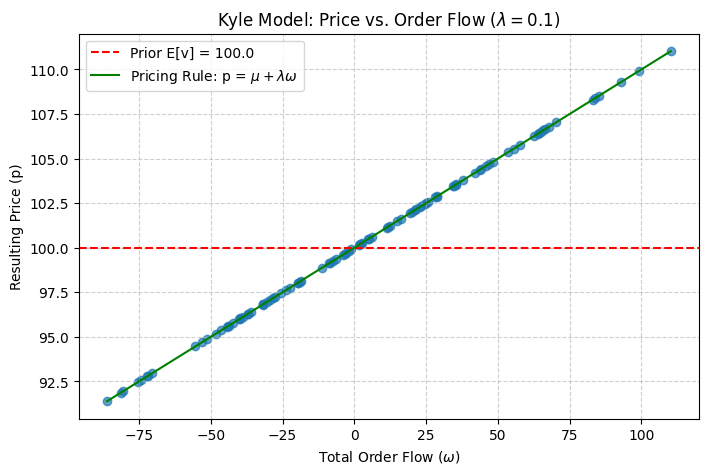

In [18]:
plt.figure(figsize=(8, 5))
plt.scatter(results_kyle['Total Order Flow (omega)'], results_kyle['Price (p)'], alpha=0.7)
plt.axhline(mu, color='red', linestyle='--', label=f'Prior E[v] = {mu}')
plt.xlabel('Total Order Flow ($\omega$)')
plt.ylabel('Resulting Price (p)')
plt.title(f'Kyle Model: Price vs. Order Flow ($\lambda = {lambda_kyle}$)')
# Plot the pricing rule line
omega_range = np.linspace(results_kyle['Total Order Flow (omega)'].min(), results_kyle['Total Order Flow (omega)'].max(), 50)
price_line = mu + lambda_kyle * omega_range
plt.plot(omega_range, price_line, color='green', label='Pricing Rule: p = $\mu + \lambda \omega$')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

**Kyle Model - Exercises:**

1.  **Change Lambda:** Rerun the Kyle simulation with a higher and a lower value for `lambda_kyle`. How does the slope of the price vs. order flow relationship change? What does this imply about market liquidity in each case?
2.  **Qualitative Dependencies:** Kyle's model shows that $\lambda$ depends on the variance of noise trades ($Var(u)$) and the variance of the true value / information asymmetry ($Var(v)$).
    * If noise trading *increases* (higher $Var(u)$), would you expect $\lambda$ to increase or decrease? Why? (Hint: How easily can the informed trader hide?)
    * If information asymmetry *increases* (higher $Var(v)$), would you expect $\lambda$ to increase or decrease? Why? (Hint: How much risk does the market maker face from the informed trader?)
3.  **Informed Trader's Perspective (Conceptual):** Imagine you are the informed trader and know the true value `v` will be 105, while `mu` is 100. You want to buy (`x > 0`). If `lambda` is very high, would you trade aggressively (large `x`) or cautiously (small `x`)? Why?

## 3. The Glosten-Milgrom Model: Information & Spreads
**Concept:** Explains the bid-ask spread as the market maker's compensation for *adverse selection risk*. The MM sets the Bid and Ask based on the expected value of the asset *conditional* on receiving a sell or buy order, respectively, using Bayesian updating.
**Formula:**
$ Ask_t = E[V | \text{Buy Order at } t] $
$ Bid_t = E[V | \text{Sell Order at } t] $
$ Spread = Ask_t - Bid_t $

Calculate Glosten-Milgrom Bid/Ask based on parameters

Parameters

In [146]:
V_High = 102.0 # Potential high value of the asset
V_Low = 98.0   # Potential low value of the asset
prior_p_high = 0.75 # MM's initial belief P(V = V_High)

In [147]:
pi = 0.4 # Probability the incoming trader is INFORMED
# Probability the incoming trader is UNINFORMED = 1 - pi

--- Calculate Conditional Probabilities Needed for Bayes ---

P(Buy | Vh): Probability of a buy order if the true value is High
  = P(Buy | Vh, Informed) * P(Informed | Vh) + P(Buy | Vh, Uninformed) * P(Uninformed | Vh)
  = 1 * pi + 0.5 * (1 - pi) # Informed buys for sure, Uninformed buys 50%

In [148]:
P_Buy_given_Vh = 1.0 * pi + 0.5 * (1.0 - pi)
P_Buy_given_Vh

0.7

P(Buy | Vl): Probability of a buy order if the true value is Low
  = P(Buy | Vl, Informed) * P(Informed | Vl) + P(Buy | Vl, Uninformed) * P(Uninformed | Vl)
  = 0 * pi + 0.5 * (1 - pi) # Informed sells (doesn't buy), Uninformed buys 50%

In [149]:
P_Buy_given_Vl = 0.0 * pi + 0.5 * (1.0 - pi)
P_Buy_given_Vl

0.3

P(Sell | Vh): Probability of a sell order if the true value is High
  = P(Sell | Vh, Informed) * P(Informed | Vh) + P(Sell | Vh, Uninformed) * P(Uninformed | Vh)
  = 0 * pi + 0.5 * (1 - pi) # Informed buys (doesn't sell), Uninformed sells 50%

In [150]:
P_Sell_given_Vh = 0.0 * pi + 0.5 * (1.0 - pi)

P(Sell | Vl): Probability of a sell order if the true value is Low
  = P(Sell | Vl, Informed) * P(Informed | Vl) + P(Sell | Vl, Uninformed) * P(Uninformed | Vl)
  = 1 * pi + 0.5 * (1 - pi) # Informed sells for sure, Uninformed sells 50%

In [151]:
P_Sell_given_Vl = 1.0 * pi + 0.5 * (1.0 - pi)

In [152]:
prior_p_low = 1.0 - prior_p_high
P_Buy = P_Buy_given_Vh * prior_p_high + P_Buy_given_Vl * prior_p_low
P_Sell = P_Sell_given_Vh * prior_p_high + P_Sell_given_Vl * prior_p_low
# Check: P_Buy + P_Sell should equal 1
# print(f"Check: P(Buy) + P(Sell) = {P_Buy + P_Sell:.2f}")

In [153]:
P_Buy

0.5999999999999999

In [154]:
P_Sell

0.39999999999999997

P(Vh | Buy) = P(Buy | Vh) * P(Vh) / P(Buy)

In [155]:
P_Vh_given_Buy = (P_Buy_given_Vh * prior_p_high) / P_Buy if P_Buy > 0 else 0
P_Vl_given_Buy = 1.0 - P_Vh_given_Buy # Or calculate: (P_Buy_given_Vl * prior_p_low) / P_Buy

P(Vl | Sell) = P(Sell | Vl) * P(Vl) / P(Sell)

In [156]:
P_Vl_given_Sell = (P_Sell_given_Vl * prior_p_low) / P_Sell if P_Sell > 0 else 0
P_Vh_given_Sell = 1.0 - P_Vl_given_Sell # Or calculate: (P_Sell_given_Vh * prior_p_high) / P_Sell

Ask = E[V | Buy] = Vh * P(Vh | Buy) + Vl * P(Vl | Buy)

In [157]:
Ask = V_High * P_Vh_given_Buy + V_Low * P_Vl_given_Buy

Bid = E[V | Sell] = Vh * P(Vh | Sell) + Vl * P(Vl | Sell)

In [158]:
Bid = V_High * P_Vh_given_Sell + V_Low * P_Vl_given_Sell

In [159]:
Bid

100.25

In [160]:
Spread = Ask - Bid

--- Print Results ---

In [161]:
print("Glosten-Milgrom Model Parameters:")
print(f"  V_High = {V_High:.2f}, V_Low = {V_Low:.2f}")
print(f"  Prior P(V=High) = {prior_p_high:.2f}")
print(f"  Probability Informed (pi) = {pi:.2f}")
print("-" * 30)
print("Calculated Quotes and Spread:")
print(f"  MM Posterior P(V=High | Buy Order) = {P_Vh_given_Buy:.3f}")
print(f"  MM Posterior P(V=Low | Sell Order) = {P_Vl_given_Sell:.3f}")
print(f"  Ask Price = E[V | Buy] = {Ask:.4f}")
print(f"  Bid Price = E[V | Sell] = {Bid:.4f}")
print(f"  Spread (Ask - Bid) = {Spread:.4f}")

Glosten-Milgrom Model Parameters:
  V_High = 102.00, V_Low = 98.00
  Prior P(V=High) = 0.75
  Probability Informed (pi) = 0.40
------------------------------
Calculated Quotes and Spread:
  MM Posterior P(V=High | Buy Order) = 0.875
  MM Posterior P(V=Low | Sell Order) = 0.438
  Ask Price = E[V | Buy] = 101.5000
  Bid Price = E[V | Sell] = 100.2500
  Spread (Ask - Bid) = 1.2500


**Glosten-Milgrom Model - Exercises:**

1.  **Vary Information Asymmetry:** Keep `pi` constant (e.g., at 0.2). Recalculate the Bid, Ask, and Spread using a wider difference between `V_High` and `V_Low` (e.g., 105 and 95) and a narrower difference (e.g., 101 and 99). How does the spread change? Explain why.
2.  **Vary Probability of Informed Trading:** Keep `V_High` and `V_Low` constant (e.g., at 102 and 98). Recalculate the Bid, Ask, and Spread using a higher `pi` (e.g., 0.5) and a lower `pi` (e.g., 0.05). How does the spread change? Explain the intuition based on the market maker's risk.
3.  **Updating Beliefs:** Suppose the MM posts the Bid/Ask calculated above. A **Buy** order arrives and executes at the Ask price. According to the model, what should the MM's *new* prior belief `P(V = V_High)` be for the *next* trade? (Hint: It's the posterior calculated after observing the first buy). If the *next* trade is a **Sell**, how would the MM update their belief again starting from this new prior?

## 4. Continuous Double Auction (CDA) & Limit Order Book (LOB)

**Concept:** Simulates the core mechanics of a modern exchange: maintaining a Limit Order Book (LOB), processing incoming Market and Limit orders according to Price-Time priority.

In [32]:
class LimitOrderBook:
    def __init__(self):
        # Using lists of dictionaries, sorted explicitly
        # For larger scale, sorted data structures (like sortedcontainers) or DataFrames are better
        self.bids = [] # List of {'price': float, 'size': int, 'time': int} sorted P descending, T ascending
        self.asks = [] # List of {'price': float, 'size': int, 'time': int} sorted P ascending, T ascending
        self.trade_log = []
        self.time = 0 # Simple discrete time counter
    def _get_next_time(self):
        self.time += 1
        return self.time
    def _add_order(self, book, price, size, timestamp, is_bid):
        order = {'price': price, 'size': size, 'time': timestamp}
        book.append(order)
        # Sort: Bids P desc, T asc; Asks P asc, T asc
        if is_bid:
            book.sort(key=lambda x: (-x['price'], x['time']))
        else:
            book.sort(key=lambda x: (x['price'], x['time']))
    def _log_trade(self, price, size, incoming_order_type, aggressor_side):
         self.trade_log.append({
             'time': self.time,
             'price': price,
             'size': size,
             'incoming_order': incoming_order_type,
             'aggressor': aggressor_side # 'BUY' or 'SELL'
         })
         print(f"--- TRADE @ T={self.time}: {size} shares at {price:.2f} ---")
         
    def limit_order(self, side, price, size):
        timestamp = self._get_next_time()
        print(f"\n>> T={timestamp}: Incoming LIMIT {side} order: {size} @ {price:.2f}")
        if side == 'BUY':
            # Check if executable against asks
            while size > 0 and self.asks and price >= self.asks[0]['price']:
                best_ask = self.asks[0]
                trade_size = min(size, best_ask['size'])
                self._log_trade(best_ask['price'], trade_size, 'LIMIT BUY', 'BUY')
                size -= trade_size
                best_ask['size'] -= trade_size
                if best_ask['size'] == 0:
                    self.asks.pop(0) # Remove filled ask

            # If order not fully filled, add remaining to bids
            if size > 0:
                print(f"   Order partially filled or non-executable. Adding {size} @ {price:.2f} to Bids.")
                self._add_order(self.bids, price, size, timestamp, is_bid=True)
        elif side == 'SELL':
            # Check if executable against bids
            while size > 0 and self.bids and price <= self.bids[0]['price']:
                best_bid = self.bids[0]
                trade_size = min(size, best_bid['size'])
                self._log_trade(best_bid['price'], trade_size, 'LIMIT SELL', 'SELL')
                size -= trade_size
                best_bid['size'] -= trade_size
                if best_bid['size'] == 0:
                    self.bids.pop(0) # Remove filled bid

            # If order not fully filled, add remaining to asks
            if size > 0:
                print(f"   Order partially filled or non-executable. Adding {size} @ {price:.2f} to Asks.")
                self._add_order(self.asks, price, size, timestamp, is_bid=False)
        self.display_lob()
    
    def market_order(self, side, size):
        timestamp = self._get_next_time()
        print(f"\n>> T={timestamp}: Incoming MARKET {side} order: {size} shares")
        original_size = size
        if side == 'BUY':
             while size > 0 and self.asks:
                best_ask = self.asks[0]
                trade_size = min(size, best_ask['size'])
                self._log_trade(best_ask['price'], trade_size, 'MARKET BUY', 'BUY')
                size -= trade_size
                best_ask['size'] -= trade_size
                if best_ask['size'] == 0:
                    self.asks.pop(0) # Remove filled ask
             if size > 0:
                 print(f"   Market order could not be fully filled. {size} shares remaining unfilled.")
        elif side == 'SELL':
            while size > 0 and self.bids:
                best_bid = self.bids[0]
                trade_size = min(size, best_bid['size'])
                self._log_trade(best_bid['price'], trade_size, 'MARKET SELL', 'SELL')
                size -= trade_size
                best_bid['size'] -= trade_size
                if best_bid['size'] == 0:
                    self.bids.pop(0) # Remove filled bid
            if size > 0:
                 print(f"   Market order could not be fully filled. {size} shares remaining unfilled.")
        self.display_lob()
    def display_lob(self, depth=5):
        print("\n--- Current Limit Order Book ---")
        print("         ASKS (Price / Size / Time)")
        # Display asks from top (best ask) down, reversed for display
        for i in range(min(depth, len(self.asks)) -1, -1, -1):
             order = self.asks[i]
             print(f"Level {min(depth, len(self.asks)) - i -1 }:    {order['price']:>6.2f} / {order['size']:<5d} / T={order['time']}")
        print("-" * 30)
        best_bid = self.bids[0]['price'] if self.bids else 'N/A'
        best_ask = self.asks[0]['price'] if self.asks else 'N/A'
        spread = self.asks[0]['price'] - self.bids[0]['price'] if self.bids and self.asks else 'N/A'
        print(f"BBO:      {best_bid} / {best_ask}   Spread: {spread}")
        print("-" * 30)
        print("         BIDS (Price / Size / Time)")
        # Display bids from top (best bid) down
        for i in range(min(depth, len(self.bids))):
            order = self.bids[i]
            print(f"Level {i}:    {order['price']:>6.2f} / {order['size']:<5d} / T={order['time']}")
        print("=" * 30)

--- Simulation ---

In [33]:
lob = LimitOrderBook()

Populate the book with initial orders (match presentation example)

In [34]:
lob._add_order(lob.bids, 10.00, 200, lob._get_next_time(), is_bid=True) # T1
lob._add_order(lob.bids, 9.99, 150, lob._get_next_time(), is_bid=True)  # T2
lob._add_order(lob.bids, 9.98, 300, lob._get_next_time(), is_bid=True)  # T3
lob._add_order(lob.asks, 10.01, 100, lob._get_next_time(), is_bid=False) # T4
lob._add_order(lob.asks, 10.02, 400, lob._get_next_time(), is_bid=False) # T5
lob._add_order(lob.asks, 10.03, 250, lob._get_next_time(), is_bid=False) # T6

In [35]:
print("Initial LOB State:")
lob.display_lob()

Initial LOB State:

--- Current Limit Order Book ---
         ASKS (Price / Size / Time)
Level 0:     10.03 / 250   / T=6
Level 1:     10.02 / 400   / T=5
Level 2:     10.01 / 100   / T=4
------------------------------
BBO:      10.0 / 10.01   Spread: 0.009999999999999787
------------------------------
         BIDS (Price / Size / Time)
Level 0:     10.00 / 200   / T=1
Level 1:      9.99 / 150   / T=2
Level 2:      9.98 / 300   / T=3


Event 1: Market Sell 150 (T7)

In [36]:
lob.market_order('SELL', 150)


>> T=7: Incoming MARKET SELL order: 150 shares
--- TRADE @ T=7: 150 shares at 10.00 ---

--- Current Limit Order Book ---
         ASKS (Price / Size / Time)
Level 0:     10.03 / 250   / T=6
Level 1:     10.02 / 400   / T=5
Level 2:     10.01 / 100   / T=4
------------------------------
BBO:      10.0 / 10.01   Spread: 0.009999999999999787
------------------------------
         BIDS (Price / Size / Time)
Level 0:     10.00 / 50    / T=1
Level 1:      9.99 / 150   / T=2
Level 2:      9.98 / 300   / T=3


Event 2: Limit Buy 200 @ 10.02 (T8)

In [37]:
lob.limit_order('BUY', 10.02, 200)


>> T=8: Incoming LIMIT BUY order: 200 @ 10.02
--- TRADE @ T=8: 100 shares at 10.01 ---
--- TRADE @ T=8: 100 shares at 10.02 ---

--- Current Limit Order Book ---
         ASKS (Price / Size / Time)
Level 0:     10.03 / 250   / T=6
Level 1:     10.02 / 300   / T=5
------------------------------
BBO:      10.0 / 10.02   Spread: 0.019999999999999574
------------------------------
         BIDS (Price / Size / Time)
Level 0:     10.00 / 50    / T=1
Level 1:      9.99 / 150   / T=2
Level 2:      9.98 / 300   / T=3


In [38]:
print("\n--- Trade Log ---")
trade_df = pd.DataFrame(lob.trade_log)
print(trade_df)


--- Trade Log ---
   time  price  size incoming_order aggressor
0     7  10.00   150    MARKET SELL      SELL
1     8  10.01   100      LIMIT BUY       BUY
2     8  10.02   100      LIMIT BUY       BUY


**CDA / LOB - Exercises:**

1.  **More Orders:** Add more events to the simulation:
    * A limit sell order arrives for 50 shares at 10.00. What happens?
    * A market buy order arrives for 500 shares. How much does it execute, and at what prices (calculate the average execution price)? What does the LOB look like afterwards?
    * A limit buy order arrives for 100 shares at 9.97. Where does it sit in the book?
2.  **Order Cancellation:** Modify the `LimitOrderBook` class to include a `cancel_order(order_id)` method. You would need to assign unique IDs to orders when they are added and store them differently (e.g., dictionaries keyed by ID) to allow efficient cancellation. Simulate adding an order and then cancelling it.
3.  **Market Depth:** Define a function `calculate_depth(lob, levels)` that returns the total size available within the first `levels` price levels on both the bid and ask side. Calculate the depth for 1 level (the BBO sizes) and 3 levels after the initial LOB setup and after Event 2 in the simulation.

## Conclusion

This notebook provided basic implementations and visualizations for the Roll, Kyle, and Glosten-Milgrom models, as well as a simple simulation of a Continuous Double Auction mechanism with a Limit Order Book. These examples illustrate the core mechanics discussed in the presentation. The exercises encourage exploring the models' sensitivities and the LOB dynamics further.